Arquivo de modelagem com dados originais do artigo Modelling Climate Change and Malaria 
Transmission de Paul E. Parham e Edwin Michael 

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import cos
from math import log

In [2]:
T1=23.2
T2=0.07
omega1=0.67
phi1=1.53

R1=85.9
R2=0.98
omega2=0.65
phi2=1.99

B_E=200
p_ME=0.9
p_ML=0.25
p_MP=0.75
tau_E=1
tau_P=1
c1=0.00554
c2=-0.06737
D1=36.5
b1=0.04
A=-0.03
B=1.31
C=-4.4
b2=0.09
tau_H=10
DD=105
Tmin=14.5
gamma= 1/120
R_L = 50
N=8558
M= 10000  #0
E_M0=5000 #0 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

In [3]:
def lotkavolterra(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, I_M0, I_H0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T_curr - T1) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M0 / N) * S_H
    dIhdt = a_curr * b2 * (I_M0 / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H0 / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H0 / N) * S_M - mu_curr * E_M - a_curr * b1 * (I_H0 / N) * S_M * l_curr
    dImdt = a_curr * b1 * (I_H0 / N) * S_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [4]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 3062
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff2499b650>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
  

In [5]:
times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

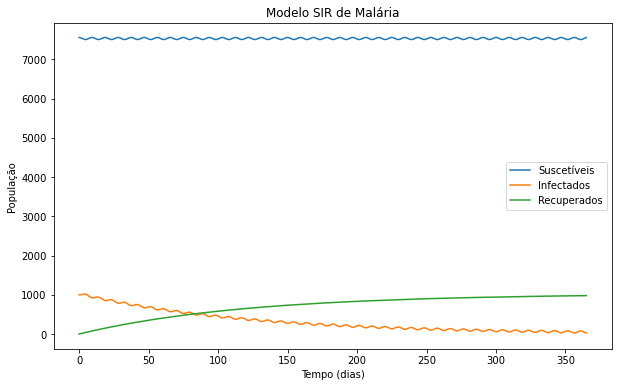

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

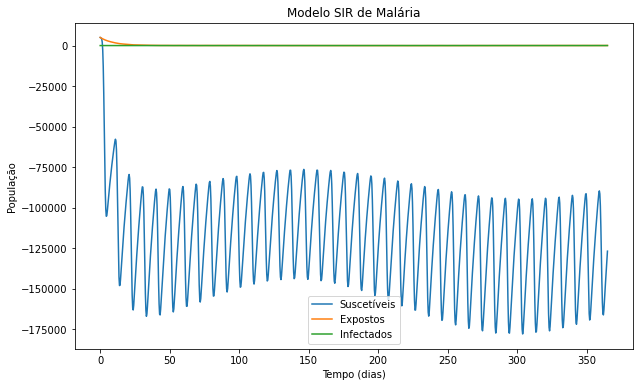

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [8]:
# Funções de temperatura e chuva fora do contexto da função lotkavolterra
def T(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

def R(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

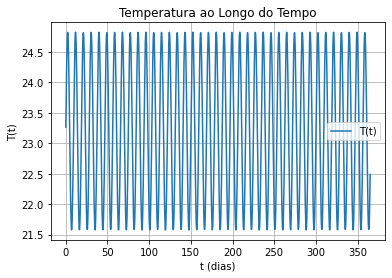

In [9]:
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
T_values = [T(t) for t in t_values]

# Plotando
plt.plot(t_values, T_values, label='T(t)')
plt.title('Temperatura ao Longo do Tempo')
plt.xlabel('t (dias)')
plt.ylabel('T(t)')
plt.legend()
plt.grid(True)
plt.show()

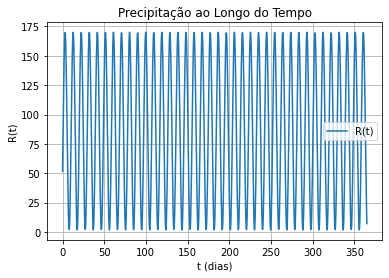

In [10]:
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
R_values = [R(t) for t in t_values]

# Plotando
plt.plot(t_values, R_values, label='R(t)')
plt.title('Precipitação ao Longo do Tempo')
plt.xlabel('t (dias)')
plt.ylabel('R(t)')
plt.legend()
plt.grid(True)
plt.show()